In [ ]:
!unzip archive.zip

**Note:** All the code for gaussian, spectral and max pooling comparison in ESC50 Classification section.

# Generate Spectrogram

In [ ]:
from __future__ import division, print_function
from os import listdir
from os.path import isfile, join

from matplotlib import pyplot as plt
import scipy.io.wavfile as wav

from tqdm import tqdm

In [ ]:
def wav_to_spectrogram(audio_path, save_path, spectrogram_dimensions=(64, 64), noverlap=16, cmap='gray_r'):
    """ Creates a spectrogram of a wav file.

    :param audio_path: path of wav file
    :param save_path:  path of spectrogram to save
    :param spectrogram_dimensions: number of pixels the spectrogram should be. Defaults (64,64)
    :param noverlap: See http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    :param cmap: the color scheme to use for the spectrogram. Defaults to 'gray_r'
    :return:
    """

    sample_rate, samples = wav.read(audio_path)

    fig = plt.figure()
    fig.set_size_inches((spectrogram_dimensions[0]/fig.get_dpi(), spectrogram_dimensions[1]/fig.get_dpi()))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.specgram(samples, cmap=cmap, Fs=2, noverlap=noverlap)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    fig.savefig(save_path, bbox_inches="tight", pad_inches=0)


def dir_to_spectrogram(audio_dir, spectrogram_dir, spectrogram_dimensions=(64, 64), noverlap=16, cmap='gray_r'):
    """ Creates spectrograms of all the audio files in a dir

    :param audio_dir: path of directory with audio files
    :param spectrogram_dir: path to save spectrograms
    :param spectrogram_dimensions: tuple specifying the dimensions in pixes of the created spectrogram. default:(64,64)
    :param noverlap: See http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    :param cmap: the color scheme to use for the spectrogram. Defaults to 'gray_r'
    :return:
    """
    file_names = [f for f in listdir(audio_dir) if isfile(join(audio_dir, f)) and '.wav' in f]

    for file_name in file_names:
        print(file_name)
        audio_path = audio_dir + file_name
        spectogram_path = spectrogram_dir + file_name.replace('.wav', '.png')
        wav_to_spectrogram(audio_path, spectogram_path, spectrogram_dimensions=spectrogram_dimensions, noverlap=noverlap, cmap=cmap)


In [ ]:
!mkdir spectrograms

In [ ]:
audio_dir = "recordings/"
spectrogram_dir = "spectrograms/"
dir_to_spectrogram(audio_dir, spectrogram_dir)

# Train Test Split

In [ ]:
!mkdir testing-spectrograms
!mkdir training-spectrograms

In [ ]:
import os
from shutil import copyfile

# As per README:
# All files of iteration 0-4 move to testing-spectrograms
# All files of iteration 5-49 move to training-spectrograms

def separate(source):
    for filename in os.listdir(source):
        first_split = filename.rsplit("_", 1)[1]
        second_split = first_split.rsplit(".", 1)[0]
        if int(second_split) <= 4:
            copyfile(source + "/" + filename, "testing-spectrograms" + "/" + filename)
        else:
            copyfile(source + "/" + filename, "training-spectrograms" + "/" + filename)

separate("spectrograms")

# My Dataset

In [ ]:
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
class SpeechData(Dataset):
  def __init__(self, data_path):
    self.path = data_path
    self.image_label_pairs = []
    for filename in os.listdir(data_path):
      label = int(filename[0])
      image = np.array([plt.imread(data_path+"/"+filename)[:,:,0]])
      image = torch.from_numpy(image)
      self.image_label_pairs.append((image, label))
      self.len = len(self.image_label_pairs)

  def __getitem__(self, index):
    return self.image_label_pairs[index]

  def __len__(self):
    return self.len

In [ ]:
BATCH_SIZE = 64
NUM_CLASSES = 10
train_dataset = SpeechData("training-spectrograms/")
test_dataset = SpeechData("testing-spectrograms/")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Train Helpers

In [ ]:
def validate(model, args, dataloader):
    criterion = nn.CrossEntropyLoss()
    total = 0
    for i, (xs, ys) in enumerate(dataloader):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = model(images)
        predict = torch.argmax(outputs, dim=1)
        # print(predict)
        # print(labels)
        total += torch.sum(labels == predict)
    return total.item() / len(test_dataset)

In [ ]:
def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(model, args, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    print("Beginning training ...")
    if args.gpu:
        model.cuda()
    start = time.time()
    # print(1)
    train_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        model.train()  # Change model to 'train' mode
        losses = []
        # print(1)
        for i, (xs, ys) in enumerate(train_loader):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            # print(labels)
            # print(images.size())
            optimizer.zero_grad()
            outputs = model(images)

            # print(outputs.view(BATCH_SIZE, NUM_CLASSES))

            loss = criterion(outputs.view(BATCH_SIZE, NUM_CLASSES), labels)
            print("i:", i, "loss:", loss)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print(
            "Epoch [%d/%d], Loss: %.4f, Time (s): %d"
            % (epoch + 1, args.epochs, avg_loss, time_elapsed)
        )
        model.eval()
        val_acc = validate(model, args, val_loader)
        valid_accs.append(val_acc)
        print(
            "Epoch [%d/%d], Validation Accuracy: %.4f"
            % (epoch + 1, args.epochs, val_acc)
        )
    return model, train_losses, valid_accs

# Train

In [ ]:
from torch.autograd import Variable
import torch.nn as nn
import torchvision
import time
import torch.nn.functional as F

In [ ]:
model = torchvision.models.vgg11()

In [ ]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model.classifier[6] = nn.Linear(4096, NUM_CLASSES)

In [ ]:
args = AttrDict()
torch.cuda.empty_cache()
args_dict = {
    "gpu": True,
    "epochs": 10,
    "learning_rate": 1e-4
}
args.update(args_dict)
final_model, train_losses, valid_accs = train(model, args, train_dataloader, test_dataloader)

Beginning training ...
i: 0 loss: tensor(2.3017, device='cuda:0', grad_fn=<NllLossBackward>)
i: 1 loss: tensor(2.3629, device='cuda:0', grad_fn=<NllLossBackward>)
i: 2 loss: tensor(2.3328, device='cuda:0', grad_fn=<NllLossBackward>)
i: 3 loss: tensor(2.3114, device='cuda:0', grad_fn=<NllLossBackward>)
i: 4 loss: tensor(2.3240, device='cuda:0', grad_fn=<NllLossBackward>)
i: 5 loss: tensor(2.2919, device='cuda:0', grad_fn=<NllLossBackward>)
i: 6 loss: tensor(2.3332, device='cuda:0', grad_fn=<NllLossBackward>)
i: 7 loss: tensor(2.3228, device='cuda:0', grad_fn=<NllLossBackward>)
i: 8 loss: tensor(2.3114, device='cuda:0', grad_fn=<NllLossBackward>)
i: 9 loss: tensor(2.3079, device='cuda:0', grad_fn=<NllLossBackward>)
i: 10 loss: tensor(2.3027, device='cuda:0', grad_fn=<NllLossBackward>)
i: 11 loss: tensor(2.3048, device='cuda:0', grad_fn=<NllLossBackward>)
i: 12 loss: tensor(2.3051, device='cuda:0', grad_fn=<NllLossBackward>)
i: 13 loss: tensor(2.3048, device='cuda:0', grad_fn=<NllLossBack

# Gaussian Pool

In [ ]:
class GaussianPooling2d(nn.AvgPool2d):
    def __init__(self, num_features, kernel_size, stride=None, padding=0, ceil_mode=False,
                 count_include_pad=True, hidden_node=None, stochasticity='HWCN', eps=1e-6):
        if stochasticity != 'HWCN' and stochasticity != 'CN' and stochasticity is not None:
            raise ValueError("gaussian pooling stochasticity has to be 'HWCN'/'CN' or None, "
                         "but got {}".format(stochasticity))
        if hidden_node is None:
            hidden_node = num_features // 2

        super(GaussianPooling2d, self).__init__(kernel_size, stride=stride, padding=padding, ceil_mode=ceil_mode,
                    count_include_pad=count_include_pad)
        self.eps = eps
        self.stochasticity = stochasticity

        self.ToHidden = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(num_features, hidden_node, kernel_size=1,  padding=0, bias=True),
            nn.BatchNorm2d(hidden_node),
            nn.ReLU(False),
        )
        self.ToMean = nn.Sequential(
            nn.Conv2d(hidden_node, num_features, kernel_size=1,  padding=0, bias=True),
            nn.BatchNorm2d(num_features),
        )
        self.ToSigma = nn.Sequential(
            nn.Conv2d(hidden_node, num_features, kernel_size=1,  padding=0, bias=True),
            nn.BatchNorm2d(num_features),
            nn.Sigmoid()
        )
        self.activation = nn.Softplus()
        
    def forward(self, input):
        mu0 = F.avg_pool2d(input, self.kernel_size, self.stride, self.padding, self.ceil_mode, self.count_include_pad)
        sig0= F.avg_pool2d(input**2, self.kernel_size, self.stride, self.padding, self.ceil_mode, self.count_include_pad)
        sig0= torch.sqrt(torch.clamp(sig0 - mu0**2, self.eps))

        Z = self.ToHidden(input)
        MU = self.ToMean(Z)

        if self.training and self.stochasticity is not None:
            SIGMA = self.ToSigma(Z)
            if self.stochasticity == 'HWCN':
                size = sig0.size()
            else:
                size = [sig0.size(0), sig0.size(1), 1, 1]
            W = self.activation(MU + SIGMA * 
                torch.randn(size, dtype=sig0.dtype, layout=sig0.layout, device=sig0.device))
        else:
            W = self.activation(MU)

        return mu0 + W*sig0

In [ ]:
gaussian_model = torchvision.models.vgg11()

In [ ]:
gaussian_model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
gaussian_model.features[2] = GaussianPooling2d(64, 2, 2)
gaussian_model.features[5] = GaussianPooling2d(128, 2, 2)
gaussian_model.features[10] = GaussianPooling2d(256, 2, 2)
gaussian_model.features[15] = GaussianPooling2d(512, 2, 2)
gaussian_model.features[20] = GaussianPooling2d(512, 2, 2)
gaussian_model.classifier[6] = nn.Linear(4096, NUM_CLASSES)

In [ ]:
args = AttrDict()
torch.cuda.empty_cache()
args_dict = {
    "gpu": True,
    "epochs": 10,
    "learning_rate": 1e-4
}
args.update(args_dict)
final_model, train_losses, valid_accs = train(gaussian_model, args, train_dataloader, test_dataloader)

Beginning training ...
i: 0 loss: tensor(2.3000, device='cuda:0', grad_fn=<NllLossBackward>)
i: 1 loss: tensor(2.2850, device='cuda:0', grad_fn=<NllLossBackward>)
i: 2 loss: tensor(2.3374, device='cuda:0', grad_fn=<NllLossBackward>)
i: 3 loss: tensor(2.3241, device='cuda:0', grad_fn=<NllLossBackward>)
i: 4 loss: tensor(2.2835, device='cuda:0', grad_fn=<NllLossBackward>)
i: 5 loss: tensor(2.3159, device='cuda:0', grad_fn=<NllLossBackward>)
i: 6 loss: tensor(2.3147, device='cuda:0', grad_fn=<NllLossBackward>)
i: 7 loss: tensor(2.2835, device='cuda:0', grad_fn=<NllLossBackward>)
i: 8 loss: tensor(2.3038, device='cuda:0', grad_fn=<NllLossBackward>)
i: 9 loss: tensor(2.3070, device='cuda:0', grad_fn=<NllLossBackward>)
i: 10 loss: tensor(2.2971, device='cuda:0', grad_fn=<NllLossBackward>)
i: 11 loss: tensor(2.3077, device='cuda:0', grad_fn=<NllLossBackward>)
i: 12 loss: tensor(2.2908, device='cuda:0', grad_fn=<NllLossBackward>)
i: 13 loss: tensor(2.3003, device='cuda:0', grad_fn=<NllLossBack

# Another Spectrum 

## Helpers

In [ ]:
!pip install pydub
!pip install librosa==0.7.2
!pip install numba==0.48.0

In [ ]:
import librosa
import os
from utils.trimmer import *
import numpy as np

In [ ]:
!mkdir padding-recordings

In [ ]:
for filename in os.listdir("recordings"):
  trim_silence_file("recordings/"+filename,200)

In [ ]:
durations = []
for filename in os.listdir("recordings"):
  durations.append(librosa.get_duration(filename="recordings/"+filename))

In [ ]:
from pydub import AudioSegment

In [ ]:
TARGET_LENGTH = max(durations)*1000
for filename in os.listdir("recordings"):
  dur = librosa.get_duration(filename="recordings/"+filename)
  silence = AudioSegment.silent(duration=TARGET_LENGTH-(1000*dur))
  audio = AudioSegment.from_wav("recordings/"+filename)
  padded = audio + silence  # Adding silence after the audio
  padded.export("padding-recordings/"+filename, format='wav')

In [ ]:
padding_durations = []
for filename in os.listdir("padding-recordings"):
  padding_durations.append(librosa.get_duration(filename="padding-recordings/"+filename))

In [ ]:
def wav2spectrum(filename):
    x, sr = librosa.load(filename)
    S = librosa.stft(x, 512)
    p = np.angle(S)

    S = np.log1p(np.abs(S))
    return S, sr


def spectrum2wav(spectrum, sr, outfile):
    # Return the all-zero vector with the same shape of `a_content`
    a = np.exp(spectrum) - 1
    p = 2 * np.pi * np.random.random_sample(spectrum.shape) - np.pi
    for i in range(50):
        S = a * np.exp(1j * p)
        x = librosa.istft(S)
        p = np.angle(librosa.stft(x, 512))
    librosa.output.write_wav(outfile, x, sr)

In [ ]:
def read_audio_from_filename(filename):
    audio, sr = librosa.load(filename)
    D = np.abs(librosa.stft(audio))**2
    audio= librosa.feature.melspectrogram(y=audio, sr=sr, S=D)
    # return librosa.util.normalize(audio)
    return np.log(audio+1e-5) #/ np.max(audio)
def convert_data(path):
    wav_filename = path
    audio = read_audio_from_filename(wav_filename)
    return audio


## Train Test Split

In [ ]:
!mkdir padding-testing
!mkdir padding-training

In [ ]:
import os
from shutil import copyfile

# As per README:
# All files of iteration 0-4 move to testing-spectrograms
# All files of iteration 5-49 move to training-spectrograms

def separate(source):
    for filename in os.listdir(source):
        first_split = filename.rsplit("_", 1)[1]
        second_split = first_split.rsplit(".", 1)[0]
        if int(second_split) <= 4:
            copyfile(source + "/" + filename, "padding-testing" + "/" + filename)
        else:
            copyfile(source + "/" + filename, "padding-training" + "/" + filename)

separate("padding-recordings")

## My Dataset

In [ ]:
import numpy as np

import os

import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import time
from tqdm import tqdm

In [ ]:
class MyWavData(Dataset):
  def __init__(self, data_path):
    self.path = data_path
    self.image_label_pairs = []
    for filename in tqdm(os.listdir(data_path)):
      label = int(filename[0])
      image = convert_data(data_path+"/"+filename)
      image = torch.from_numpy(np.array([image]))
      self.image_label_pairs.append((image, label))
      self.len = len(self.image_label_pairs)

  def __getitem__(self, index):
    return self.image_label_pairs[index]

  def __len__(self):
    return self.len

In [ ]:
BATCH_SIZE = 32
NUM_CLASSES = 10
train_dataset = MyWavData("padding-training/")
test_dataset = MyWavData("padding-testing/")

100%|██████████| 300/300 [00:19<00:00, 15.01it/s]


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Train

In [ ]:
model = torchvision.models.vgg11(progress=True)

In [ ]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model.classifier[6] = nn.Linear(4096, NUM_CLASSES)

In [ ]:
args = AttrDict()
torch.cuda.empty_cache()
args_dict = {
    "gpu": True,
    "epochs": 10,
    "learning_rate": 1e-4
}
args.update(args_dict)
final_model, train_losses, valid_accs = train(model, args, train_dataloader, test_dataloader)

## VAE

### Model

In [ ]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    model = torchvision.models.vgg11()
    model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    self.encoder_features = nn.Sequential(
        model.features,
        model.avgpool,
        nn.Flatten(),
        nn.Linear(in_features=25088, out_features=4096, bias=True),
        nn.ReLU(),
        nn.Linear(4096, 4096),
        nn.ReLU()
    )
    self.encoder_fc_mu = nn.Linear(4096, 512)
    self.encoder_fc_logvar = nn.Linear(4096, 512)
    self.decoder1 = nn.Sequential(
        nn.Linear(512, 4096),
        nn.ReLU(),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Linear(4096, 4096)
    )
    self.decoder2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=512,out_channels=512,stride=(2,2), padding=(1,0), dilation=(1,1),kernel_size=(3,3),output_padding=(1,0)),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=512,out_channels=512,stride=(2,2),padding=(1,0),kernel_size=(3,3), output_padding=(1,0)),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=512,out_channels=256,stride=(2,2),padding=(1,0),kernel_size=(3,3),output_padding=(1,0)),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=256,out_channels=128,stride=(2,2),padding=(1,1),kernel_size=(3,3),output_padding=(1,1)),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=128,out_channels=64,stride=(2,2),padding=(1,0),kernel_size=(3,3),output_padding=(1,0)),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=64,out_channels=1,stride=(1,1),padding=(1,1),kernel_size=(3,3))
    )

  def forward(self, x):
    mu, logvar = self.encoder(x)
    z = self.reparametrize(mu, logvar)
    return self.decoder(z), mu, logvar


  def decoder(self, x):
    m = self.decoder1(x)
    b, _ = m.size()
    m = torch.reshape(m, (b, 512, 4, 2))
    m = self.decoder2(m)
    return m

  def encoder(self, x):
    encode_feature = self.encoder_features(x)
    return self.encoder_fc_mu(encode_feature), self.encoder_fc_logvar(encode_feature)

  def reparametrize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    eps = Variable(std.data.new(std.size()).normal_())
    return eps.mul(std).add_(mu)

### Train

In [ ]:
reconstruction_function = nn.MSELoss()
# reconstruction_function.size_average = False

def loss_function(recon_x, x, mu, logvar):
    # print(1)
    # print(recon_x.size(), x.size())
    BCE = reconstruction_function(recon_x.view(-1, 11904), x.view(-1, 11904))
    # print(2)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

In [ ]:
def train_vae(model, args, training_dataloader):
  optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
  if args.gpu:
    model.cuda()
  # print(1)
  for epoch in range(args.epochs):
    model.train()
    # print(2)
    train_loss = 0
    for i, (data, _) in enumerate(training_dataloader):
      # print(data.size())
      data = Variable(data)
      if args.gpu:
        data = data.cuda()
      optimizer.zero_grad()
      recon_batch, mu, logvar = model(data)
      # print(4)
      loss = loss_function(recon_batch, data, mu, logvar)
      # print(5)
      loss.backward()
      train_loss += loss
      optimizer.step()
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, i * len(data), len(training_dataloader.dataset),
          100. * i / len(training_dataloader),
          loss / len(data)))

In [ ]:
model = VAE()

In [ ]:
args = AttrDict()
# torch.cuda.empty_cache()
model.cpu()
args_dict = {
    "gpu": True,
    "epochs": 10,
    "lr": 1e-5
}
args.update(args_dict)
train_vae(model, args, train_dataloader)

Train Epoch: 0 [0/2700 (0%)]	Loss: 13.571806
Train Epoch: 0 [32/2700 (1%)]	Loss: 6.599683
Train Epoch: 0 [64/2700 (2%)]	Loss: 5.046446
Train Epoch: 0 [96/2700 (4%)]	Loss: 4.598898
Train Epoch: 0 [128/2700 (5%)]	Loss: 4.452844
Train Epoch: 0 [160/2700 (6%)]	Loss: 4.335359
Train Epoch: 0 [192/2700 (7%)]	Loss: 4.213621
Train Epoch: 0 [224/2700 (8%)]	Loss: 4.160006
Train Epoch: 0 [256/2700 (10%)]	Loss: 4.086947
Train Epoch: 0 [288/2700 (11%)]	Loss: 4.041572
Train Epoch: 0 [320/2700 (12%)]	Loss: 3.922266
Train Epoch: 0 [352/2700 (13%)]	Loss: 3.986371
Train Epoch: 0 [384/2700 (14%)]	Loss: 3.969279
Train Epoch: 0 [416/2700 (15%)]	Loss: 3.919347
Train Epoch: 0 [448/2700 (17%)]	Loss: 3.892809
Train Epoch: 0 [480/2700 (18%)]	Loss: 3.884821
Train Epoch: 0 [512/2700 (19%)]	Loss: 3.857819
Train Epoch: 0 [544/2700 (20%)]	Loss: 3.872778
Train Epoch: 0 [576/2700 (21%)]	Loss: 3.843979
Train Epoch: 0 [608/2700 (23%)]	Loss: 3.847171
Train Epoch: 0 [640/2700 (24%)]	Loss: 3.800467
Train Epoch: 0 [672/2700 

## Visualization

### Spectrogram

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def read_audio_from_filename(filename):
    audio, sr = librosa.load(filename)
    D = np.abs(librosa.stft(audio))**2
    audio= librosa.feature.melspectrogram(y=audio, sr=sr, S=D)
    # return librosa.util.normalize(audio)
    return audio #/ np.max(audio)
def convert_data(path):
    wav_filename = path
    audio = read_audio_from_filename(wav_filename)
    return audio

In [ ]:
data = convert_data("padding-training/9_george_20.wav")

In [ ]:
input = torch.tensor(np.array([[data]]))

In [ ]:
rec_x = model(input.cuda())[0].cpu().detach().numpy()

In [ ]:
rec_x = rec_x.reshape((128, 93))

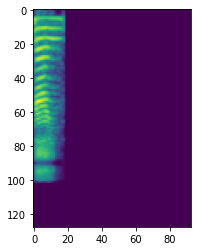

In [ ]:
plt.imshow(data)

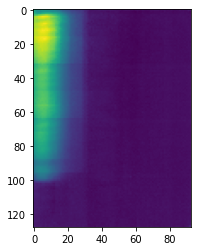

In [ ]:
plt.imshow(rec_x)

In [ ]:
res = librosa.feature.inverse.mel_to_audio(np.exp(rec_x))

In [ ]:
librosa.output.write_wav("test.wav",res*100,22050)

In [ ]:
from torchsummary import summary
model.cuda()
summary(model, (1,128,93))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 128, 93]             640
              ReLU-2          [-1, 64, 128, 93]               0
         MaxPool2d-3           [-1, 64, 64, 46]               0
            Conv2d-4          [-1, 128, 64, 46]          73,856
              ReLU-5          [-1, 128, 64, 46]               0
         MaxPool2d-6          [-1, 128, 32, 23]               0
            Conv2d-7          [-1, 256, 32, 23]         295,168
              ReLU-8          [-1, 256, 32, 23]               0
            Conv2d-9          [-1, 256, 32, 23]         590,080
             ReLU-10          [-1, 256, 32, 23]               0
        MaxPool2d-11          [-1, 256, 16, 11]               0
           Conv2d-12          [-1, 512, 16, 11]       1,180,160
             ReLU-13          [-1, 512, 16, 11]               0
           Conv2d-14          [-1, 512,

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### tsne

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [ ]:
data = convert_data("padding-training/0_george_10.wav")

In [ ]:
mus = []
labels = []
model.eval()
for filename in tqdm(os.listdir("padding-training")):
  data = convert_data("padding-training/" + filename)
  labels.append(int(filename[0]))
  mu = model(torch.from_numpy(np.array([[data]])).cuda())[1]
  mu = mu.detach().cpu().numpy()
  mus.append(mu)

100%|██████████| 2700/2700 [03:15<00:00, 13.78it/s]


In [ ]:
latent_mus = np.array(mus).reshape(2700, 512)
tsne = TSNE(n_components=2)
tsne.fit_transform(latent_mus)

array([[ 22.211197,  19.889269],
       [-16.362526, -10.446285],
       [ 12.339453,  -9.28806 ],
       ...,
       [ 26.949837,  50.113228],
       [-26.28647 , -17.892342],
       [-45.011856,   7.561608]], dtype=float32)

No handles with labels found to put in legend.


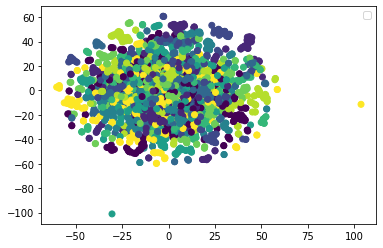

In [ ]:
plt.legend()
plt.scatter(tsne.embedding_[:,0].reshape(-1), tsne.embedding_[:,1].reshape(-1), c=labels, label=labels)
plt.show()

# 1D Process

## Dataset

In [ ]:
import os
import torch
import librosa

import numpy as np

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [ ]:
class OneDimDataset(Dataset):
  def __init__(self, datapath):
    for filename in tqdm(os.listdir(datapath)):
      filename = os.join(datapath, filename)
      y, sr = librosa.load(filename)
      

# ESC50 Classification

In [1]:
!git clone https://github.com/karolpiczak/ESC-50.git

Cloning into 'ESC-50'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 4151 (delta 8), reused 1 (delta 0), pack-reused 4136
Receiving objects: 100% (4151/4151), 878.78 MiB | 32.84 MiB/s, done.
Resolving deltas: 100% (255/255), done.
Checking out files: 100% (2011/2011), done.


In [2]:
!pip install pydub
!pip install librosa==0.7.2
!pip install numba==0.48.0
!pip install torchvision==0.7.0
!pip install torch==1.6.0

     |████████████████████████████████| 1.6MB 14.2MB/s 
  Created wheel for librosa: filename=librosa-0.7.2-cp37-none-any.whl size=1612885 sha256=e97b21e1f0f0c561fa6268a22a33d6674cb2da118e0a0175a426e223087e8481
  Stored in directory: /root/.cache/pip/wheels/4c/6e/d7/bb93911540d2d1e44d690a1561871e5b6af82b69e80938abef
Successfully built librosa
  Found existing installation: librosa 0.8.0
    Uninstalling librosa-0.8.0:
      Successfully uninstalled librosa-0.8.0
     |████████████████████████████████| 3.6MB 15.3MB/s 
     |████████████████████████████████| 20.2MB 1.3MB/s 
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
     |████████████████████████████████| 5.9MB 12.4MB/s 
     |████████████████████████████████| 748.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'l

In [3]:
import os
import time

import librosa

import torch
import torchvision

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split

## Train Helpers

In [4]:
def validate(model, args, dataloader):
    criterion = nn.CrossEntropyLoss()
    total = 0
    for i, (xs, ys) in enumerate(dataloader):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = model(images)
        predict = torch.argmax(outputs, dim=1)
        # print(predict)
        # print(labels)
        total += torch.sum(labels == predict)
    return total.item() / len(test_data)

In [5]:
def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

In [6]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(model, args, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    print("Beginning training ...")
    if args.gpu:
        model.cuda()
    start = time.time()
    # print(1)
    train_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        model.train()  # Change model to 'train' mode
        losses = []
        # print(1)
        for i, (xs, ys) in enumerate(train_loader):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            # print(labels)
            # print(images.size())
            optimizer.zero_grad()
            outputs = model(images)

            # print(outputs.view(BATCH_SIZE, NUM_CLASSES))

            loss = criterion(outputs.view(BATCH_SIZE, NUM_CLASSES), labels)
            print("i:", i, "loss:", loss)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print(
            "Epoch [%d/%d], Loss: %.4f, Time (s): %d"
            % (epoch + 1, args.epochs, avg_loss, time_elapsed)
        )
        model.eval()
        val_acc = validate(model, args, val_loader)
        valid_accs.append(val_acc)
        print(
            "Epoch [%d/%d], Validation Accuracy: %.4f"
            % (epoch + 1, args.epochs, val_acc)
        )
    return model, train_losses, valid_accs

## Dataset

In [7]:
def read_audio_from_filename(filename):
    audio, sr = librosa.load(filename)
    D = np.abs(librosa.stft(audio))**2
    audio= librosa.feature.melspectrogram(y=audio, sr=sr, S=D)
    # return librosa.util.normalize(audio)
    return np.log(audio+1e-5) #/ np.max(audio)
    
def convert_data(path):
    wav_filename = path
    audio = read_audio_from_filename(wav_filename)
    return audio

In [8]:
class ES50Dataset(Dataset):
  def __init__(self, path):
    self.image_label_pairs = []
    for filename in tqdm(os.listdir(path)):
      file = os.path.join(path, filename)
      data = convert_data(file)
      data = torch.from_numpy(np.array([data]))
      r_dash_idx = filename.rfind("-")
      dot_idx = filename.rfind(".")
      label = int(filename[r_dash_idx+1:dot_idx])
      self.image_label_pairs.append((data, label))
    self._len = len(self.image_label_pairs)

  def __getitem__(self, idx):
    return self.image_label_pairs[idx]
  
  def __len__(self):
    return self._len

In [9]:
data = ES50Dataset("ESC-50/audio")

100%|██████████| 2000/2000 [07:38<00:00,  4.36it/s]


In [10]:
train_data, test_data = random_split(data, (1400, 600))

In [11]:
BATCH_SIZE = 32
NUM_CLASSES = 50

In [12]:
train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

## VGG Train

In [13]:
vgg_model = torch.hub.load('pytorch/vision:v0.7.0', 'vgg16', pretrained=False)

Downloading: "https://github.com/pytorch/vision/archive/v0.7.0.zip" to /root/.cache/torch/hub/v0.7.0.zip


In [14]:
vgg_model.features[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
vgg_model.classifier[6] = nn.Linear(4096, NUM_CLASSES)

In [15]:
args = AttrDict()
torch.cuda.empty_cache()
args_dict = {
    "gpu": True,
    "epochs": 15,
    "learning_rate": 1e-4
}
args.update(args_dict)

trained_vgg, vgg_train_loss, vgg_val_acc = train(vgg_model, args, train_dataloader, test_dataloader)

Beginning training ...
i: 0 loss: tensor(4.3805, device='cuda:0', grad_fn=<NllLossBackward>)
i: 1 loss: tensor(4.5607, device='cuda:0', grad_fn=<NllLossBackward>)
i: 2 loss: tensor(4.2096, device='cuda:0', grad_fn=<NllLossBackward>)
i: 3 loss: tensor(4.0441, device='cuda:0', grad_fn=<NllLossBackward>)
i: 4 loss: tensor(4.0536, device='cuda:0', grad_fn=<NllLossBackward>)
i: 5 loss: tensor(4.0063, device='cuda:0', grad_fn=<NllLossBackward>)
i: 6 loss: tensor(3.9288, device='cuda:0', grad_fn=<NllLossBackward>)
i: 7 loss: tensor(3.9076, device='cuda:0', grad_fn=<NllLossBackward>)
i: 8 loss: tensor(3.8671, device='cuda:0', grad_fn=<NllLossBackward>)
i: 9 loss: tensor(3.9177, device='cuda:0', grad_fn=<NllLossBackward>)
i: 10 loss: tensor(3.9752, device='cuda:0', grad_fn=<NllLossBackward>)
i: 11 loss: tensor(3.9351, device='cuda:0', grad_fn=<NllLossBackward>)
i: 12 loss: tensor(3.9248, device='cuda:0', grad_fn=<NllLossBackward>)
i: 13 loss: tensor(3.9077, device='cuda:0', grad_fn=<NllLossBack

In [16]:
args_dict = {
    "gpu": True,
    "epochs": 15,
    "learning_rate": 5e-5
}
args.update(args_dict)

In [17]:
trained_vgg2, vgg_train_loss2, vgg_val_acc2 = train(vgg_model, args, train_dataloader, test_dataloader)

Beginning training ...
i: 0 loss: tensor(0.8044, device='cuda:0', grad_fn=<NllLossBackward>)
i: 1 loss: tensor(0.3303, device='cuda:0', grad_fn=<NllLossBackward>)
i: 2 loss: tensor(0.9527, device='cuda:0', grad_fn=<NllLossBackward>)
i: 3 loss: tensor(0.5143, device='cuda:0', grad_fn=<NllLossBackward>)
i: 4 loss: tensor(0.6814, device='cuda:0', grad_fn=<NllLossBackward>)
i: 5 loss: tensor(0.5531, device='cuda:0', grad_fn=<NllLossBackward>)
i: 6 loss: tensor(0.4078, device='cuda:0', grad_fn=<NllLossBackward>)
i: 7 loss: tensor(0.5223, device='cuda:0', grad_fn=<NllLossBackward>)
i: 8 loss: tensor(0.4115, device='cuda:0', grad_fn=<NllLossBackward>)
i: 9 loss: tensor(0.6570, device='cuda:0', grad_fn=<NllLossBackward>)
i: 10 loss: tensor(0.5652, device='cuda:0', grad_fn=<NllLossBackward>)
i: 11 loss: tensor(0.4261, device='cuda:0', grad_fn=<NllLossBackward>)
i: 12 loss: tensor(0.2806, device='cuda:0', grad_fn=<NllLossBackward>)
i: 13 loss: tensor(0.3829, device='cuda:0', grad_fn=<NllLossBack

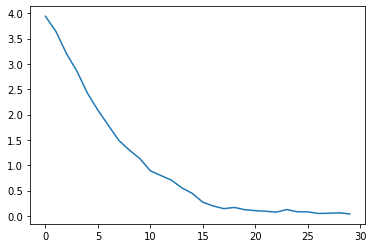

In [ ]:
plt.plot(vgg_train_loss+vgg_train_loss2)

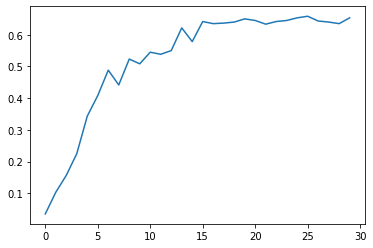

In [ ]:
plt.plot(vgg_val_acc+vgg_val_acc2)

## Spectral Pool

In [18]:
class SpectralPooling2d(nn.Module):
    def __init__(self):
        super(SpectralPooling2d, self).__init__()

        self.kernel_size = 2

    def crop_spectrum(self, z, H, W):
        '''
            z: [bs, c, M, N, 2]
            Return: [bs, c, H, H, 2]
        '''
        M, N = z.size(-3), z.size(-2)
        topleft = z[..., :M//2-H//2+1, :N//2-W//2+1, :]
        topright = z[..., :M//2-H//2+1, N//2+W//2:, :]
        bottomleft = z[..., M//2+H//2:, :N//2-W//2+1, :]
        bottomright = z[...,M//2+H//2:, N//2+W//2:, :]
        top = torch.cat((topleft, topright), dim=3)
        bottom = torch.cat((bottomleft, bottomright), dim=3)

        return torch.cat((top, bottom),dim=2)


        #return z[..., M//2-H//2:M//2+H//2, N//2-W//2:N//2+W//2, :]

    def pad_spectrum(self, z, M, N):
        '''
            z: [bs, c, H, W, 2]
            Return: [bs, c, M, N, 2]
        '''
        H, W = z.size(-3), z.size(-2)
        z_real, z_imag = z[..., 0], z[..., 1]
        pad = torch.nn.ZeroPad2d((N-W)//2, (N-W)//2, (M-H)//2, (M-H)//2)
        return torch.stack([pad(z_real), pad(z_imag)], dim = -1)

    def treat_corner_cases(self, freq_map):
        '''
            freq_map: [bs, c, M, N, 2]
        '''
        S = [(0, 0)]
        M, N = freq_map.size(-3), freq_map.size(-2)

        if M % 2 == 1:
            S.append((M // 2, 0))
        if N % 2 == 1:
            S.append((0, N // 2))
        if M % 2 == 1 and N % 2 == 1:
            S.append((M // 2, N // 2))

        for h, w in S:
            freq_map[..., h, w, 1].zero_()

        return freq_map, S

    def remove_redundancy(self, y):
        '''
            y: input gradient map [bs, c, M, N, 2]
        '''
        z, S = self.treat_corner_cases(y)
        I = []
        M, N = y.size(-3), y.size(-2)

        for m in range(M):
            for n in range(N // 2 + 1):
                if (m, n) not in S:
                    if (m, n) not in I:
                        z[..., m, n, :].mul_(2)
                        I.append((m, n))
                        I.append(((M - m) % M, (N - n) % N))
                    else:
                        z[..., m, n, :].zero_()
        
        return z

    def recover_map(self, y):
        z, S = self.treat_corner_cases(y)
        I = []
        M, N = y.size(-3), y.size(-2)

        for m in range(M):
            for n in range(N // 2 + 1):
                if (m, n) not in S:
                    if (m, n) not in I:
                        z[..., m, n, :].mul_(0.5)
                        z[..., (M-m)%M, (N-n)%N] = z[..., m, n, :]
                        I.append((m, n))
                        I.append(((M - m) % M, (N - n) % N))
                    else:
                        z[..., m, n, :].zero_()

        return z

    def forward(self, x):
        M, N = x.size(-2), x.size(-1)
        H, W = M // self.kernel_size, N // self.kernel_size

        x_fft = torch.rfft(x, 2, onesided = False)
        crop_x_fft = self.crop_spectrum(x_fft, H, W)
        crop_x_fft, _ = self.treat_corner_cases(crop_x_fft)
        pool_x = torch.irfft(crop_x_fft, 2, onesided = False)
        return pool_x

    def backward(self, gRgx):
        H, W = gRgx.size(-2), gRgx.size(-1)
        M, N = H * self.kernel_size, W * self.kernel_size

        z = torch.rfft(gRgx, 2, onesided = False)
        z = self.remove_redundancy(z)
        z = self.pad_spectrum(z, M, N)
        z = self.recover_map(z)
        gRx = torch.irfft(z, 2, onesided = False)

        return gRx

In [20]:
spec_model = torch.hub.load('pytorch/vision:v0.7.0', 'vgg16', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.7.0


In [21]:
spec_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
spec_model.features[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
spec_model.features[4] = SpectralPooling2d()
spec_model.features[9] = SpectralPooling2d()
spec_model.features[16] = SpectralPooling2d()
spec_model.features[23] = SpectralPooling2d()
spec_model.features[30] = SpectralPooling2d()

spec_model.classifier[6] = nn.Linear(4096, NUM_CLASSES)

In [23]:
args = AttrDict()
torch.cuda.empty_cache()
args_dict = {
    "gpu": True,
    "epochs": 15,
    "learning_rate": 1e-4
}
args.update(args_dict)

trained_spec, sepc_train_loss, spec_val_acc = train(spec_model, args, train_dataloader, test_dataloader)

Beginning training ...
i: 0 loss: tensor(266.1021, device='cuda:0', grad_fn=<NllLossBackward>)
i: 1 loss: tensor(283.6748, device='cuda:0', grad_fn=<NllLossBackward>)
i: 2 loss: tensor(105.5407, device='cuda:0', grad_fn=<NllLossBackward>)
i: 3 loss: tensor(62.5696, device='cuda:0', grad_fn=<NllLossBackward>)
i: 4 loss: tensor(32.6129, device='cuda:0', grad_fn=<NllLossBackward>)
i: 5 loss: tensor(27.7397, device='cuda:0', grad_fn=<NllLossBackward>)
i: 6 loss: tensor(18.4972, device='cuda:0', grad_fn=<NllLossBackward>)
i: 7 loss: tensor(11.7358, device='cuda:0', grad_fn=<NllLossBackward>)
i: 8 loss: tensor(9.7201, device='cuda:0', grad_fn=<NllLossBackward>)
i: 9 loss: tensor(9.6729, device='cuda:0', grad_fn=<NllLossBackward>)
i: 10 loss: tensor(7.1260, device='cuda:0', grad_fn=<NllLossBackward>)
i: 11 loss: tensor(6.2066, device='cuda:0', grad_fn=<NllLossBackward>)
i: 12 loss: tensor(5.7213, device='cuda:0', grad_fn=<NllLossBackward>)
i: 13 loss: tensor(5.1679, device='cuda:0', grad_fn=<

In [24]:
args = AttrDict()
torch.cuda.empty_cache()
args_dict = {
    "gpu": True,
    "epochs": 15,
    "learning_rate": 5e-5
}
args.update(args_dict)

trained_spec2, sepc_train_loss2, spec_val_acc2 = train(spec_model, args, train_dataloader, test_dataloader)

Beginning training ...
i: 0 loss: tensor(0.6982, device='cuda:0', grad_fn=<NllLossBackward>)
i: 1 loss: tensor(1.2828, device='cuda:0', grad_fn=<NllLossBackward>)
i: 2 loss: tensor(0.9552, device='cuda:0', grad_fn=<NllLossBackward>)
i: 3 loss: tensor(0.8892, device='cuda:0', grad_fn=<NllLossBackward>)
i: 4 loss: tensor(0.6705, device='cuda:0', grad_fn=<NllLossBackward>)
i: 5 loss: tensor(0.7041, device='cuda:0', grad_fn=<NllLossBackward>)
i: 6 loss: tensor(0.6516, device='cuda:0', grad_fn=<NllLossBackward>)
i: 7 loss: tensor(0.8422, device='cuda:0', grad_fn=<NllLossBackward>)
i: 8 loss: tensor(0.4325, device='cuda:0', grad_fn=<NllLossBackward>)
i: 9 loss: tensor(0.5803, device='cuda:0', grad_fn=<NllLossBackward>)
i: 10 loss: tensor(0.7253, device='cuda:0', grad_fn=<NllLossBackward>)
i: 11 loss: tensor(0.4474, device='cuda:0', grad_fn=<NllLossBackward>)
i: 12 loss: tensor(0.6320, device='cuda:0', grad_fn=<NllLossBackward>)
i: 13 loss: tensor(0.8368, device='cuda:0', grad_fn=<NllLossBack

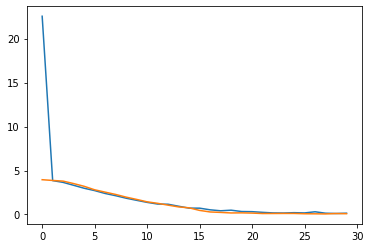

In [25]:
plt.plot(sepc_train_loss+sepc_train_loss2)
plt.plot(vgg_train_loss+vgg_train_loss2)

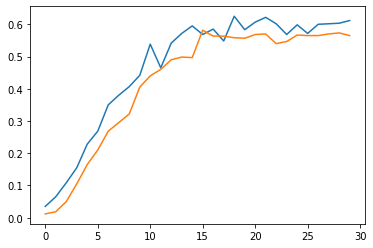

In [26]:
plt.plot(spec_val_acc+spec_val_acc2)
plt.plot(vgg_val_acc+vgg_val_acc2)

## Gaussian Pooling

In [27]:
class GaussianPooling2d(nn.AvgPool2d):
    def __init__(self, num_features, kernel_size, stride=None, padding=0, ceil_mode=False,
                 count_include_pad=True, hidden_node=None, stochasticity='HWCN', eps=1e-6):
        if stochasticity != 'HWCN' and stochasticity != 'CN' and stochasticity is not None:
            raise ValueError("gaussian pooling stochasticity has to be 'HWCN'/'CN' or None, "
                         "but got {}".format(stochasticity))
        if hidden_node is None:
            hidden_node = num_features // 2

        super(GaussianPooling2d, self).__init__(kernel_size, stride=stride, padding=padding, ceil_mode=ceil_mode,
                    count_include_pad=count_include_pad)
        self.eps = eps
        self.stochasticity = stochasticity

        self.ToHidden = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(num_features, hidden_node, kernel_size=1,  padding=0, bias=True),
            nn.BatchNorm2d(hidden_node),
            nn.ReLU(False),
        )
        self.ToMean = nn.Sequential(
            nn.Conv2d(hidden_node, num_features, kernel_size=1,  padding=0, bias=True),
            nn.BatchNorm2d(num_features),
        )
        self.ToSigma = nn.Sequential(
            nn.Conv2d(hidden_node, num_features, kernel_size=1,  padding=0, bias=True),
            nn.BatchNorm2d(num_features),
            nn.Sigmoid()
        )
        self.activation = nn.Softplus()
        
    def forward(self, input):
        mu0 = F.avg_pool2d(input, self.kernel_size, self.stride, self.padding, self.ceil_mode, self.count_include_pad)
        sig0= F.avg_pool2d(input**2, self.kernel_size, self.stride, self.padding, self.ceil_mode, self.count_include_pad)
        sig0= torch.sqrt(torch.clamp(sig0 - mu0**2, self.eps))

        Z = self.ToHidden(input)
        MU = self.ToMean(Z)

        if self.training and self.stochasticity is not None:
            SIGMA = self.ToSigma(Z)
            if self.stochasticity == 'HWCN':
                size = sig0.size()
            else:
                size = [sig0.size(0), sig0.size(1), 1, 1]
            W = self.activation(MU + SIGMA * 
                torch.randn(size, dtype=sig0.dtype, layout=sig0.layout, device=sig0.device))
        else:
            W = self.activation(MU)

        return mu0 + W*sig0

In [29]:
gaussian_model = torch.hub.load('pytorch/vision:v0.7.0', 'vgg16', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.7.0


In [30]:
gaussian_model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
gaussian_model.features[4] = GaussianPooling2d(64, 2, 2)
gaussian_model.features[9] = GaussianPooling2d(128, 2, 2)
gaussian_model.features[16] = GaussianPooling2d(256, 2, 2)
gaussian_model.features[23] = GaussianPooling2d(512, 2, 2)
gaussian_model.features[30] = GaussianPooling2d(512, 2, 2)
gaussian_model.classifier[6] = nn.Linear(4096, NUM_CLASSES)

In [31]:
args = AttrDict()
torch.cuda.empty_cache()
args_dict = {
    "gpu": True,
    "epochs": 15,
    "learning_rate": 1e-4
}
args.update(args_dict)

trained_gaussian, gaussian_train_loss, gaussian_val_acc = train(gaussian_model, args, train_dataloader, test_dataloader)

Beginning training ...
i: 0 loss: tensor(3.9882, device='cuda:0', grad_fn=<NllLossBackward>)
i: 1 loss: tensor(4.5650, device='cuda:0', grad_fn=<NllLossBackward>)
i: 2 loss: tensor(4.1412, device='cuda:0', grad_fn=<NllLossBackward>)
i: 3 loss: tensor(3.9493, device='cuda:0', grad_fn=<NllLossBackward>)
i: 4 loss: tensor(3.9406, device='cuda:0', grad_fn=<NllLossBackward>)
i: 5 loss: tensor(3.9946, device='cuda:0', grad_fn=<NllLossBackward>)
i: 6 loss: tensor(3.9095, device='cuda:0', grad_fn=<NllLossBackward>)
i: 7 loss: tensor(3.9210, device='cuda:0', grad_fn=<NllLossBackward>)
i: 8 loss: tensor(3.9373, device='cuda:0', grad_fn=<NllLossBackward>)
i: 9 loss: tensor(3.9338, device='cuda:0', grad_fn=<NllLossBackward>)
i: 10 loss: tensor(3.9312, device='cuda:0', grad_fn=<NllLossBackward>)
i: 11 loss: tensor(3.9092, device='cuda:0', grad_fn=<NllLossBackward>)
i: 12 loss: tensor(3.9104, device='cuda:0', grad_fn=<NllLossBackward>)
i: 13 loss: tensor(3.9065, device='cuda:0', grad_fn=<NllLossBack

In [32]:
args = AttrDict()
torch.cuda.empty_cache()
args_dict = {
    "gpu": True,
    "epochs": 15,
    "learning_rate": 5e-5
}
args.update(args_dict)

trained_gaussian2, gaussian_train_loss2, gaussian_val_ac2c = train(gaussian_model, args, train_dataloader, test_dataloader)

Beginning training ...
i: 0 loss: tensor(0.8254, device='cuda:0', grad_fn=<NllLossBackward>)
i: 1 loss: tensor(0.5186, device='cuda:0', grad_fn=<NllLossBackward>)
i: 2 loss: tensor(0.9218, device='cuda:0', grad_fn=<NllLossBackward>)
i: 3 loss: tensor(0.7783, device='cuda:0', grad_fn=<NllLossBackward>)
i: 4 loss: tensor(0.7142, device='cuda:0', grad_fn=<NllLossBackward>)
i: 5 loss: tensor(0.6686, device='cuda:0', grad_fn=<NllLossBackward>)
i: 6 loss: tensor(0.4030, device='cuda:0', grad_fn=<NllLossBackward>)
i: 7 loss: tensor(0.5712, device='cuda:0', grad_fn=<NllLossBackward>)
i: 8 loss: tensor(0.3023, device='cuda:0', grad_fn=<NllLossBackward>)
i: 9 loss: tensor(0.7354, device='cuda:0', grad_fn=<NllLossBackward>)
i: 10 loss: tensor(1.0288, device='cuda:0', grad_fn=<NllLossBackward>)
i: 11 loss: tensor(0.7016, device='cuda:0', grad_fn=<NllLossBackward>)
i: 12 loss: tensor(0.3884, device='cuda:0', grad_fn=<NllLossBackward>)
i: 13 loss: tensor(1.0187, device='cuda:0', grad_fn=<NllLossBack

In [45]:
max(spec_val_acc+spec_val_acc2)

0.625

In [46]:
max(vgg_val_acc+vgg_val_acc2)

0.5816666666666667

In [47]:
max(gaussian_val_acc+gaussian_val_ac2c)

0.635

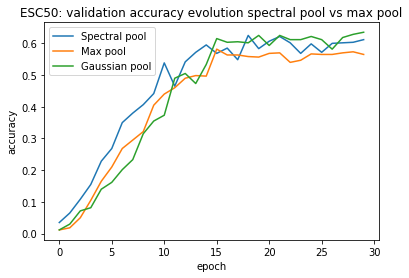

In [39]:
plt.plot(spec_val_acc+spec_val_acc2, label="Spectral pool")
plt.plot(vgg_val_acc+vgg_val_acc2, label="Max pool")
plt.plot(gaussian_val_acc+gaussian_val_ac2c, label="Gaussian pool")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("ESC50: validation accuracy evolution spectral pool vs max pool")
plt.show()

In [42]:
min(sepc_train_loss+sepc_train_loss2)

0.11362633789174778

In [43]:
min(vgg_train_loss+vgg_train_loss2)

0.06593107496020059

In [44]:
min(gaussian_train_loss+gaussian_train_loss2)

0.10005761236818723

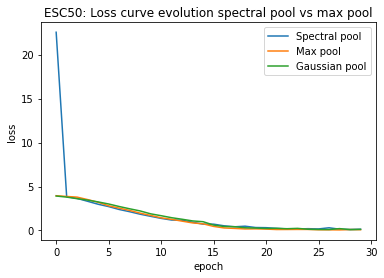

In [41]:
plt.plot(sepc_train_loss+sepc_train_loss2, label="Spectral pool")
plt.plot(vgg_train_loss+vgg_train_loss2, label="Max pool")
plt.plot(gaussian_train_loss+gaussian_train_loss2, label="Gaussian pool")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("ESC50: Loss curve evolution spectral pool vs max pool")
plt.show()

# Play

In [ ]:
import librosa
import numpy as np

In [ ]:
y, sr = librosa.load('padding-recordings/6_george_10.wav')
normalizedy = librosa.util.normalize(y)

stft = librosa.stft(normalizedy)
mel = librosa.feature.melspectrogram(S=stft)
mellog = np.log(mel + 1e-9)
melnormalized = librosa.util.normalize(mellog)

In [ ]:
melnormalized.shape

(128, 94)

In [ ]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def read_audio_from_filename(filename):
    audio, sr = librosa.load(filename)
    D = np.abs(librosa.stft(audio))**2
    audio= librosa.feature.melspectrogram(y=audio, sr=sr, S=D)
    # return librosa.util.normalize(audio)
    return audio #/ np.max(audio)
def convert_data():
    wav_filename = "padding-recordings/4_george_10.wav"
    audio = read_audio_from_filename(wav_filename)
    return audio
specto = convert_data()
# res = librosa.feature.inverse.mel_to_audio(specto)

In [ ]:
specto.shape

(128, 94)

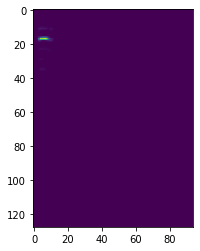

In [ ]:
plt.imshow(specto)

In [ ]:
librosa.output.write_wav("test.wav",res*100,22050)

In [ ]:
np.max(normalizedy)

1.0

In [ ]:
np.max(aa[0])

0.69762343

In [ ]:
import numpy as np
import scipy.signal
import scipy.io.wavfile

# read file
file    = "recordings/0_george_0.wav"
fs, sig = scipy.io.wavfile.read(file)
nperseg = int(fs * 0.001 * 20)

# process
frequencies, times, spectrogram = scipy.signal.spectrogram(sig, fs, nperseg=nperseg, window=scipy.signal.hann(nperseg))


In [ ]:
temp = plt.imread("testing-spectrograms/0_george_0.png")[:,:,0]

In [ ]:
s, sr = wav2spectrum("padding-recordings/0_george_5.wav")

In [ ]:
spectrum2wav(s, sr, "test.wav")

In [ ]:
s.shape

(257, 375)

In [ ]:
audio_signal = librosa.core.spectrum.griffinlim(s)
print(audio_signal, audio_signal.shape)

# write output
scipy.io.wavfile.write('test.wav', fs, np.array(audio_signal, dtype=np.int16))